In [76]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
from mpl_toolkits.mplot3d import Axes3D
np.set_printoptions(precision=9)
np.set_printoptions(suppress=True)


In [77]:
def cross_product(vec1,vec2):
    return np.cross(vec1, vec2)

def norm(vec):
    return np.linalg.norm(vec)

def get_direction_to_center(center, vec):
    return vec - center

def calc_distance_between_rotations(rot1, rot2):
    R = np.matmul(rot1, np.transpose(rot2))
    trace = R.trace()
    difference_angle = np.rad2deg(np.arccos((trace - 1) / 2.0))
    return difference_angle
    
def calc_angle(vec1, vec2):
    cross_prod = cross_product(vec1, vec2)
    return np.arctan(cross_prod / norm(cross_prod))

def calculate_rotation_axis(vec1, vec2):
    cross_prod = cross_product(vec1, vec2)
    return(cross_prod / norm(cross_prod))

def create_skew_symmetric_rotation_matrix(rot_axis):
    skew_sym_mat = np.zeros(shape=(3,3))
    x = rot_axis.item(0)
    y = rot_axis.item(1)
    z = rot_axis.item(2)
    skew_sym_mat.itemset((0,0), 0)
    skew_sym_mat.itemset((1,0), z)
    skew_sym_mat.itemset((2,0), -y)
    skew_sym_mat.itemset((0,1), -z)
    skew_sym_mat.itemset((1,1), 0)
    skew_sym_mat.itemset((2,1), x)
    skew_sym_mat.itemset((0,2), y)
    skew_sym_mat.itemset((1,2), -x)
    skew_sym_mat.itemset((0,2), 0)
    #np.array([[0, -k[2], k[1]],[k[2], 0, -k[0]],[-k[1], k[0], 0]])
    skew_sym_mat = np.array([[0, -z, y],[z, 0, -x],[-y, x, 0]])
    return skew_sym_mat
    
def create_simple_rotation_matrix(vec1, vec2):
    axis = cross_product(vec1, vec2)
    axis = axis/norm(axis)
    print(axis)
    angle = np.arccos(np.dot(norm(vec1),norm(axis)))
    print(angle)
    rot_mat = np.zeros(shape=(3,3))
    print(np.sin(angle))
    rcos = np.cos(angle)
    rsin = np.sin(angle)
    u = axis.item(0)
    v = axis.item(1)
    w = axis.item(2)
    
    rot_mat.itemset((0,0), rcos +  u * u * (1- rcos))
    rot_mat.itemset((1,0), w * rsin +  v * u * (1- rcos))
    rot_mat.itemset((2,0), -v *  rsin +  w * u * (1- rcos))
    rot_mat.itemset((0,1), -w * rsin +  u * v * (1- rcos))
    rot_mat.itemset((1,1), rcos +  v * v * (1- rcos))
    rot_mat.itemset((2,1), u * rsin +  w * v * (1- rcos))
    rot_mat.itemset((0,2), v * rsin +  u * w* (1- rcos))
    rot_mat.itemset((1,2), -u * rsin +  v * w * (1- rcos))
    rot_mat.itemset((2,2), rcos +  w * w * (1- rcos))
    
    return rot_mat

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def calculate_theta(actual_tool_direction, desired_tool_direction):
    cross = cross_product(desired_tool_direction, actual_tool_direction)
    cross_norm =norm(cross)
    dot = actual_tool_direction.dot(desired_tool_direction)
    #np.arccos(np.dot(v, vr_desired) / np.linalg.norm(v)*np.linalg.norm(vr_desired))
    #tangens = np.dot(actual_tool_direction, desired_tool_direction) / np.linalg.norm(actual_tool_direction) * np.linalg.norm(desired_tool_direction)
    #tangens = np.arccos(tangens)
    tangens = np.arctan(cross_norm/ dot)
    return tangens

def calculate_rotation_axis(actual_tool_direction, desired_tool_direction):
    cross = np.cross(actual_tool_direction, desired_tool_direction)
    cross_norm = norm(cross)
    
    return cross/cross_norm

# def calculate_desired_orientattion(skew_sym_matrix, theta, actual_rot_matrix):
#     identity = np.identity(3)
#     first_term = identity + skew_sym_matrix * np.sin(theta) + 2 * np.multiply(skew_sym_matrix, skew_sym_matrix)
#     print(first_term)
#     rot_desired = np.multiply(first_term, actual_rot_matrix)
#     return rot_desired
    
def get_tool_direction(troc_point, desired_point):
    return desired_point - troc_point

def look_at(center, target, up):
    f = (center - target)
    f = f/np.linalg.norm(f)
    s = np.cross(f, up)
    s = s/np.linalg.norm(s)

    u = np.cross(s, f)
    u = u/np.linalg.norm(u)

    m = np.zeros((3, 3))
    m[0] = s
    m[1] = u
    m[2] = -f

    return m

def calculate_rodriguez_formular_vector_form(current_vector, desired_vector):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector, desired_vector)
    vr_according_to_vector_form = current_vector *np.cos(theta) + (np.cross(rot_axis,current_vector)*np.sin(theta)) + rot_axis*(np.dot(rot_axis, current_vector))*(1.0-np.cos(theta))
    return vr_according_to_vector_form
    
def calculate_rodriguez_formular_matrix_form(current_vector, desired_vector):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector,desired_vector)
    skew_sym_matrix = create_skew_symmetric_rotation_matrix(rot_axis)
    identity = np.eye(3)
    rot_mat = identity + np.sin(theta) * skew_sym_matrix + (1 - np.cos(theta)) * np.matmul(skew_sym_matrix, skew_sym_matrix)
    #rot_mat = identity + skew_sym_mat * np.sin(theta) + 2 * np.matmul(skew_sym_mat, skew_sym_mat) * np.sin(theta/2.0) * np.sin(theta/2.0) 
    return rot_mat

def calculate_quaternion(current_vector, desired_vector):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector,desired_vector)
    quaternion = Quaternion(axis= rot_axis, angle = theta)
    quaternion = quaternion / quaternion.norm
    return quaternion

def calculate_desired_rotation_quat(current_vector, desired_vector, last_rot_quat):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector, desired_vector)
    quaternion = Quaternion(axis= rot_axis, angle = theta)
    quaternion = quaternion / quaternion.norm
    rot_quat = last_rot_quat * quaternion
    rot_quat = rot_quat / rot_quat.norm
    return rot_quat
    
def calculate_desired_rotation(current_vector, desired_vector, last_rot_mat):
    theta = calculate_theta(current_vector, desired_vector)
    rot_axis = calculate_rotation_axis(current_vector, desired_vector)
    skew_sym_mat = create_skew_symmetric_rotation_matrix(rot_axis)
    identity = np.eye(3)
    rot_mat = identity + skew_sym_mat * np.sin(theta) + 2 * np.matmul(skew_sym_mat, skew_sym_mat) * np.sin(theta/2.0) * np.sin(theta/2.0) 
    rot_mat = np.matmul(rot_mat, last_rot_mat)
    return rot_mat

In [78]:
#distance between quaternions

#psy2 metric
def distance_quaternions(quat1, quat2):
    quat_diff = quat1 - quat2
    print("difference")
    print(quat_diff.norm)
    quat_sum = quat1 + quat2
    print("sum")
    print(quat_sum.norm)
    return min(quat_diff.norm, quat_sum.norm)


def dot_product_quaternions(quat1, quat2): 
    dot = quat1.w * quat2.w + quat1.x * quat2.x + quat1.y * quat2.y + quat1.z * quat2.z
    return dot

#psy3 metric 
def angle_quaternions(quat1, quat2):
    dot_prod = dot_product_quaternions(quat1, quat2)
    return np.arccos(np.abs(dot_prod))


#psy4 metric
def distance_quaternions2(quat1, quat2):
    dot_prod = dot_product_quaternions(quat1, quat2)
    return (1 - np.abs(dot_prod))

#distance between rotation matrices
#LA.norm(b, 'fro')
#psy5 metric
def deviation_from_identity_matrix(rot_mat1, rot_mat2):
    deviation = np.eye(3) - np.matmul(rot_mat1, np.transpose(rot_mat2))
    rot_dev = np.linalg.norm(deviation, 'fro')
    return rot_dev

def convert_m3_to_m2(m3_val):
    return np.sqrt(2 * (1 - np.cos(m3_val)))

def convert_m3_to_m4(m3_val):
    return 1 - np.cos(m3_val)

def convert_m3_to_m5(m3_val):
    return 2 * np.sqrt(2) * np.sin(m3_val)

In [79]:
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import proj3d
from matplotlib.pyplot import figure

import pylab

class Arrow3D(mpatches.FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        mpatches.FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        mpatches.FancyArrowPatch.draw(self, renderer)

#m=float(raw_input())

vector_handles=[]
used_labels=[]

def draw_vector(vec, color, label1, figure, axis):

    a = Arrow3D([vec.item(0),0],[vec.item(1),0],[vec.item(2),0],label=label1, mutation_scale=10, lw=1, arrowstyle="-|>", color=color)
    figure.patches.append(a)
    axis.add_artist(a)
    
    if label1 not in used_labels:
        used_labels.append(label1)
        vector_handles.append(a)
    
    return a

def draw_coordinate_system(coord_mat, center, figure, axis):
    x_vec = coord_mat[0]
    y_vec = coord_mat[1] 
    z_vec = coord_mat[2]
    
    x_arrow = Arrow3D([center.item(0),x_vec.item(0)],[center.item(1),x_vec.item(1)],[center.item(2),x_vec.item(2)], mutation_scale=10, lw=1, arrowstyle="-|>", color="red")
    y_arrow = Arrow3D([center.item(0),y_vec.item(0)],[center.item(1),y_vec.item(1)],[center.item(2),y_vec.item(2)], mutation_scale=10, lw=1, arrowstyle="-|>", color="green")
    z_arrow = Arrow3D([center.item(0),z_vec.item(0)],[center.item(1),z_vec.item(1)],[center.item(2),z_vec.item(2)], mutation_scale=10, lw=1, arrowstyle="-|>", color="blue")
    figure.patches.append(x_arrow)
    axis.add_artist(x_arrow)
    figure.patches.append(y_arrow)
    axis.add_artist(y_arrow)
    figure.patches.append(z_arrow)
    axis.add_artist(z_arrow)
    
def create_points_on_circle(number, radius, height):
    number_vectors = number
    rad = 2 * np.pi / number_vectors
    radius = radius
    vectors = []

    for i in range(number_vectors):
        x = np.cos(rad * i) * radius
        y = np.sin(rad * i) * radius
        z = height
        vec = np.array([x,y,z])
        vectors.append(vec)
    return vectors

def create_points_on_line(start, end, steps):
    
    diff = end - start
    pts = []
    for i in range(steps):
        pt = start + (1.0 / steps) * i * diff
        pts.append(pt)
        
    return pts
    

def create_points_on_sphere(number, radius):
    x_vec = np.random.uniform(-1,1,number)
    y_vec = np.random.uniform(-1,1,number)
    z_vec = np.random.uniform(-1,1,number)
    vectors =[]
    for i in range(number):
        vec = np.array([x_vec[i], y_vec[i], z_vec[i]])
        vec = vec / np.linalg.norm(vec)
        vec = vec * radius
        vectors.append(vec)
    return vectors    
    
# la_center = np.array([vectors[0].item(0), vectors[0].item(1), vectors[0].item(2)])
# look_at_mat = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))    
# draw_coordinate_system(look_at_mat, la_center,figure, axis)    
# for v in vectors:
#         draw_vector(v, "orange", "trajectory points")
def visualize_rodriguez_vector_transform(vectors, figure, axis):
    curr_vec = vectors[0]
    for v in range(1, len(vectors) - 1):
        des_vec = vectors[v]
        #print("desired vecctor = {}".format(des_vec))
        vr = calculate_rodriguez_formular_vector_form(curr_vec, des_vec)
        quat = calculate_quaternion(curr_vec, des_vec)
        vr = quat.rotate(curr_vec)
        #print("rodriguez vector form result = {}".format(vr))
        draw_vector(vr/np.linalg.norm(vr), "purple", "calculated points", figure, axis)
        curr_vec = vr

def visualize_rodriguez_matrix_orientation(vectors, figure, axis):
    curr_vec = vectors[0]
    look_at_mat  = look_at(curr_vec,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))
    diff = []
    actual_points = []
    actual_points.append(curr_vec)
    dist_between_rotations = []
    init = True
    last_mat = look_at_mat
    
    for v in range(1, len(vectors) ):
        
        
        des_vec = vectors[v]
        #print("desired vecctor = {}".format(des_vec))
        rot_rod = calculate_rodriguez_formular_matrix_form(curr_vec, des_vec)
        
        
        if init == True:
            dist_between_rotations.append(deviation_from_identity_matrix(last_mat, rot_rod))
        
        vr =  np.matmul(rot_rod, curr_vec)
        actual_points.append(vr)
        la_center = vr
        
        look_at_mat = np.matmul(look_at_mat, np.transpose(rot_rod))
       
        draw_coordinate_system(look_at_mat, la_center, figure, axis)
        curr_vec = vr
        last_mat = rot_rod
        
        if init == False:
            init = True
    
        
    return actual_points, dist_between_rotations
    #print(mean / len(diff))
        

def visualize_rodriguez_matrix_orientation_quat(vectors, figure, axis):
    curr_vec = vectors[0]
    look_at_mat  = Quaternion(matrix=look_at(curr_vec,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0])))
    look_at_mat = look_at_mat / look_at_mat.norm
    diff = []
    actual_points = []
    actual_points.append(curr_vec)
    dist_between_rotations = []
    init = False
    last_mat = look_at_mat
    
    for v in range(1, len(vectors) ):
        
        des_vec = vectors[v]
        #print("desired vecctor = {}".format(des_vec))
        rot_rod = calculate_quaternion(curr_vec, des_vec)
        
        #if init == True:
           # dist_between_rotations.append(calc_distance_between_rotations(last_mat, rot_rod))
        
        vr =  rot_rod.rotate(curr_vec)
        #actual_points.append(vr)
        la_center = vr
        
        dist_between_rotations.append(angle_quaternions(last_mat, rot_rod))
        
        look_at_mat =  look_at_mat * rot_rod.conjugate 
       
        draw_coordinate_system(look_at_mat.rotation_matrix, la_center, figure, axis)
        curr_vec = vr
        last_mat = rot_rod
        
        
        if init == False:
            init = True
    
        
    return actual_points, dist_between_rotations
    #print(mean / len(diff))
        
   
def visualize_rodriguez_advanced_matrix_orientation(vectors, figure, axis):
    la_center = np.array([vectors[0].item(0), vectors[0].item(1), vectors[0].item(2)])
    look_at_mat = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))
    actual_points = []
    curr_vec = vectors[0]
    
    des_vec = vectors[1]
    
    actual_points.append(curr_vec)
    actual_points.append(des_vec)
    rot_mat_adv = calculate_desired_rotation(curr_vec, des_vec, np.eye(3))#calculate_rodriguez_formular_matrix_form(curr_vec, vectors[1])
    curr_vec = vectors[1]
    dist_between_rotations = []
    
    for v in range(2, len(vectors) ):
        
        des_vec = vectors[v]
        rot_rod_adv = calculate_desired_rotation(curr_vec, des_vec, rot_mat_adv)
        vr = np.matmul(rot_rod_adv, curr_vec)
        actual_points.append(vr)
        curr_vec = vr
        
        la_center = vr
        dist_between_rotations.append(calc_distance_between_rotations(rot_mat_adv, rot_rod_adv))
        look_at_mat = np.matmul(look_at_mat,np.transpose(rot_rod_adv))
        draw_coordinate_system(look_at_mat, la_center, figure, axis)
        rot_mat_adv = rot_rod_adv

    return actual_points, dist_between_rotations

def visualize_rodriguez_advanced_matrix_orientation_quat(vectors, figure, axis):
    la_center = np.array([vectors[0].item(0), vectors[0].item(1), vectors[0].item(2)])
    look_at_mat = Quaternion(matrix = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0])))
    actual_points = []
    curr_vec = vectors[0]
    
    des_vec = vectors[1]
    
    actual_points.append(curr_vec)
    actual_points.append(des_vec)
    rot_mat_adv = Quaternion(matrix=calculate_desired_rotation(curr_vec, des_vec, np.eye(3)))#calculate_desired_rotation_quat(curr_vec, des_vec, look_at_mat)#calculate_rodriguez_formular_matrix_form(curr_vec, vectors[1])
    curr_vec = vectors[1]
    dist_between_rotations = []
    
    for v in range(2, len(vectors) ):
        
        des_vec = vectors[v]
        rot_rod_adv = Quaternion(matrix = calculate_desired_rotation(curr_vec, des_vec, rot_mat_adv.rotation_matrix))
        rot_rod_adv = rot_rod_adv / rot_rod_adv.norm
        vr = rot_rod_adv.rotate(curr_vec)
        actual_points.append(vr)
        curr_vec = vr
        
        la_center = vr
        #dist_between_rotations.append(calc_distance_between_rotations(rot_mat_adv, rot_rod_adv))
        look_at_mat = look_at_mat * rot_rod_adv.conjugate
        draw_vector(vr/np.linalg.norm(vr), "purple", "calculated points", figure, axis)
        draw_coordinate_system(look_at_mat.rotation_matrix, la_center, figure, axis)
        rot_mat_adv = rot_rod_adv

    return actual_points#, dist_between_rotations
    
def rmse(predictions, targets):

    err_dict = {
      "x_err": 0.0,
      "y_err": 0.0,
      "z_err": 0.0
    }
    err = 0.0
    for i in range(len(predictions)):
        err_vec = targets[i] - predictions[i]
        err_dict["x_err"] = err_dict["x_err"] + np.power(err_vec.item(0),2)
        err_dict["y_err"] = err_dict["y_err"] + np.power(err_vec.item(1),2)
        err_dict["z_err"] = err_dict["z_err"] + np.power(err_vec.item(2),2)
    
    err_dict["x_err"] = np.sqrt(err_dict["x_err"] / len(predictions))
    err_dict["y_err"] = np.sqrt(err_dict["y_err"]  / len(predictions))
    err_dict["z_err"] = np.sqrt(err_dict["z_err"] / len(predictions))

    return err_dict            

def rcm_error(predictions, targets, troc_point):

    err = 0.0
    
    for i in range(len(predictions)):
        act_dir = troc_point - targets[i]
        calc_dir = troc_point - predictions[i]
        err = err + np.linalg.norm(np.cross(act_dir, calc_dir))

        err = err/len(predictions)
    return err     

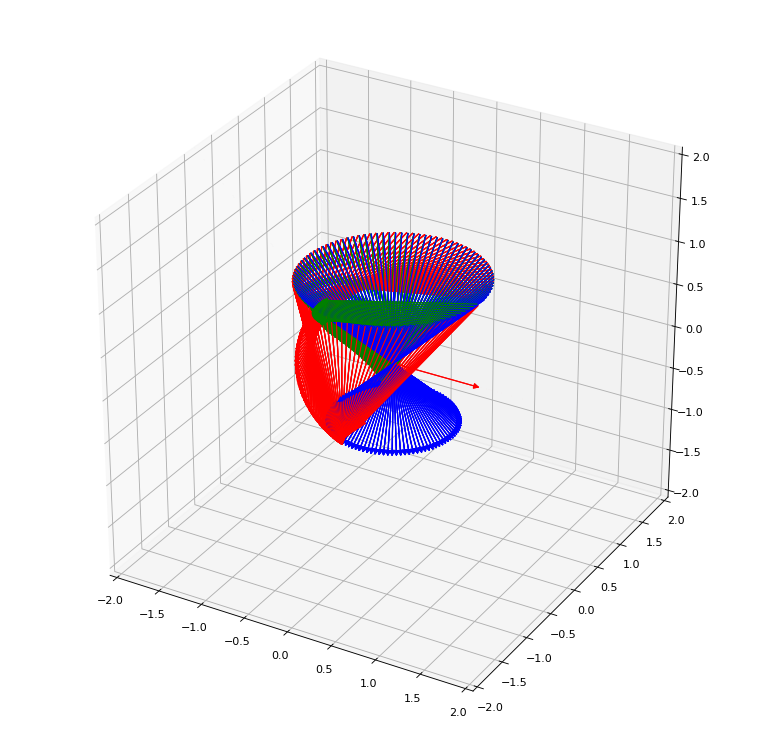

In [80]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)
vectors = create_points_on_circle(10, 1.0, 1.0)
draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)

curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))

start = np.array([1.0, 1.0, 1.0])
end = np.array([-1.0, 1.0, 1.0])

#pts = create_points_on_line(start, end, 10)
pts = create_points_on_circle(100, 1.0, 1.0)
calc_points_quat, diff_quat = visualize_rodriguez_matrix_orientation_quat(pts,fig, ax)
calc_points_mat, diff_mat = visualize_rodriguez_matrix_orientation(pts,fig, ax)


mapped_dist = []
for d in diff_quat:
    mapped_dist.append(convert_m3_to_m5(d))

diff_quat_mat = []
for i in range(len(diff_quat)):
    diff_quat_mat.append(diff_mat[i] - mapped_dist[i])
    
# print("Matrix distance")
# print(diff_mat)
# print("Mapped quaternions")
# print(mapped_dist)
# print("Differences")
# print(diff_quat_mat)
#visualize_rodriguez_vector_transform(pts,fig, ax)
#print(len(calc_points))
#print(calc_points)
#rms = rmse(calc_points, pts)
#print(rms)

# rcm_err =  rcm_error(calc_points, pts, np.array([0.0, 0.0,0.0]))
# print("rcm error:")
# print(rcm_err)    

# print("Distance between angles")
# print(dist)

# ax.view_init(60, 60)
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')
# plt.show()

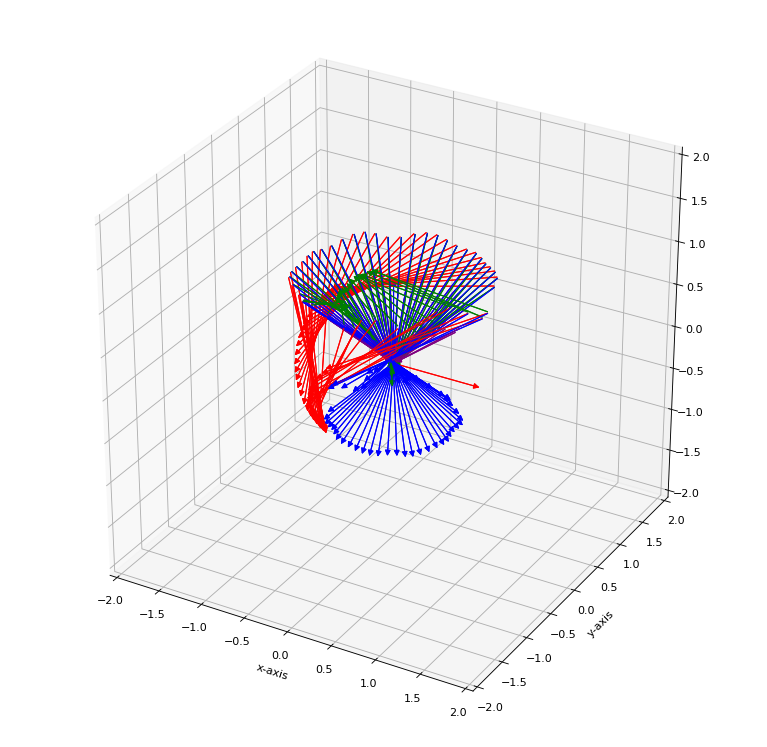

In [81]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)
vectors = create_points_on_circle(100, 1.0, 1.0)
draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)

curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))

start = np.array([1.0, 1.0, 1.0])
end = np.array([-1.0, 1.0, 1.0])

#pts = create_points_on_line(start, end, 10)
pts = create_points_on_circle(50, 1.0, 1.0)
calc_points = visualize_rodriguez_advanced_matrix_orientation_quat(pts,fig, ax)
#visualize_rodriguez_vector_transform(pts,fig, ax)
#print(len(calc_points))
#print(calc_points)
#rms = rmse(calc_points, pts)
#print(rms)

# rcm_err =  rcm_error(calc_points, pts, np.array([0.0, 0.0,0.0]))
# print("rcm error:")
# print(rcm_err)    

# print("Distance between angles")
# print(dist)

#ax.view_init(60, 60)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos


1
Distance between angles
[1.2419402355934566, 0.006442529825408873, 0.0060227647503036845, 0.004774377380303284, 0.0026683021452672566, nan, 0.0026683021452672566, 0.004774377380303284, 0.0060227647503036845]


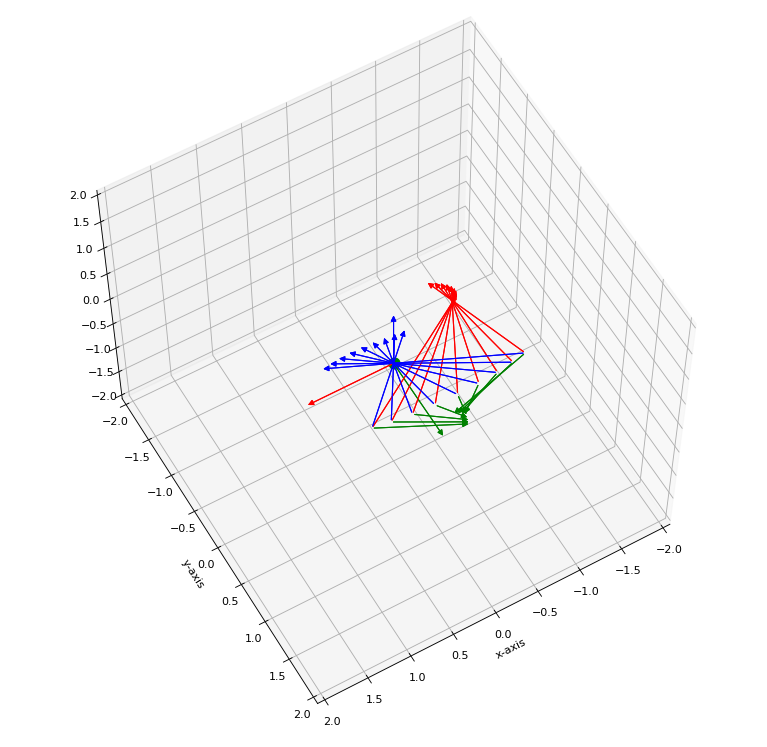

In [82]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)
vectors = create_points_on_circle(500, 1.0, 1.0)
draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)

curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))

start = np.array([1.0, 1.0, 1.0])
end = np.array([-1.0, 1.0, 1.0])

pts = create_points_on_line(start, end, 10)
calc_points, dist = visualize_rodriguez_matrix_orientation_quat(pts,  fig, ax)

print(len(calc_points))
#print(calc_points)
# rms = rmse(calc_points, pts)
# print(rms)
# rcm_err =  rcm_error(calc_points, pts, np.array([0.0, 0.0,0.0]))
# print("rcm error:")
# print(rcm_err)

print("Distance between angles")
print(dist)

ax.view_init(60, 60)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

{'x_err': 0.05517643312712517, 'y_err': 0.05275779933401629, 'z_err': 0.025415762214472934}
rcm error:
0.0011309870967157111
Distance between angles
[2.5453750101814734, 0.22606460342115625, 2.5752373653941807, 2.5752034059238724, 0.030065356761896516, 2.514987965293915, 2.5143855027967583, 0.22360428199484678, 2.6034939414378653, 2.602124124430966, 0.05877228291306781, 2.485671811556719, 2.482305357504691, 0.21843567502342912, 2.628214455076096, 2.622533431145771, 0.08416078088403645, 2.4598120883336647, 2.4501053541958586, 0.21065051860983888, 2.6477152405740427, 2.63388647746449, 0.10457195940870175, 2.4397327285981487, 2.4197372827243924, 0.20073444412616723, 2.660618273485971, 2.6349626768127288, 0.11882959802636144, 2.4274431969068373, 2.3940903163329574, 0.18987034129726554, 2.665902213706989, 2.6258674421636763, 0.1264069277631748, 2.424371539724794, 2.376547477356555, 0.1800785149323752, 2.662964945455991, 2.607800835256052, 0.12757463678830128, 2.431134290077528, 2.3701781002

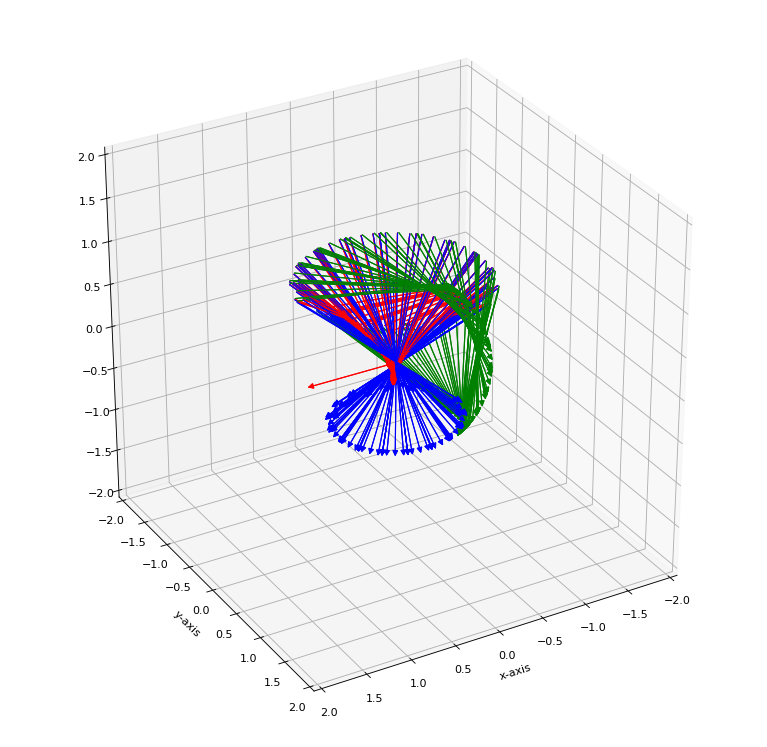

In [83]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)
vectors = create_points_on_circle(500, 1.0, 1.0)
draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)
# # for v in vectors:
# #     draw_vector(v, "red", "", fig, ax)
curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))


plt.xlabel('x-axis')
plt.ylabel('y-axis')
pts = create_points_on_circle(100, 1.0, 1.0)
start = np.array([1.0, 1.0, 1.0])
end = np.array([-1.0, 1.0, 1.0])

calc_points, dist = visualize_rodriguez_advanced_matrix_orientation(pts,  fig, ax)
rms = rmse(calc_points, pts)
print(rms)

rcm_err =  rcm_error(calc_points, pts, np.array([0.0, 0.0,0.0]))
print("rcm error:")
print(rcm_err)    

print("Distance between angles")
print(dist)

ax.view_init(30, 60)
plt.show()

Distance between angles
[1.1786927933789777, 0.000986879278595451, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.000986879278595451, 0.0009868792784829524, 0.0009868792784829524, 0.000986879278595451, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.000986879278595451, 0.0009868792784829524, 0.000986879278595451, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.0009868792784829524, 0.000986879278595451, 0.0009868792784829524, 0.0009868792784829524, 0.000986879278595451, 0.0009868792784829524, 0.0009868792784829524, 0.00098687927848295

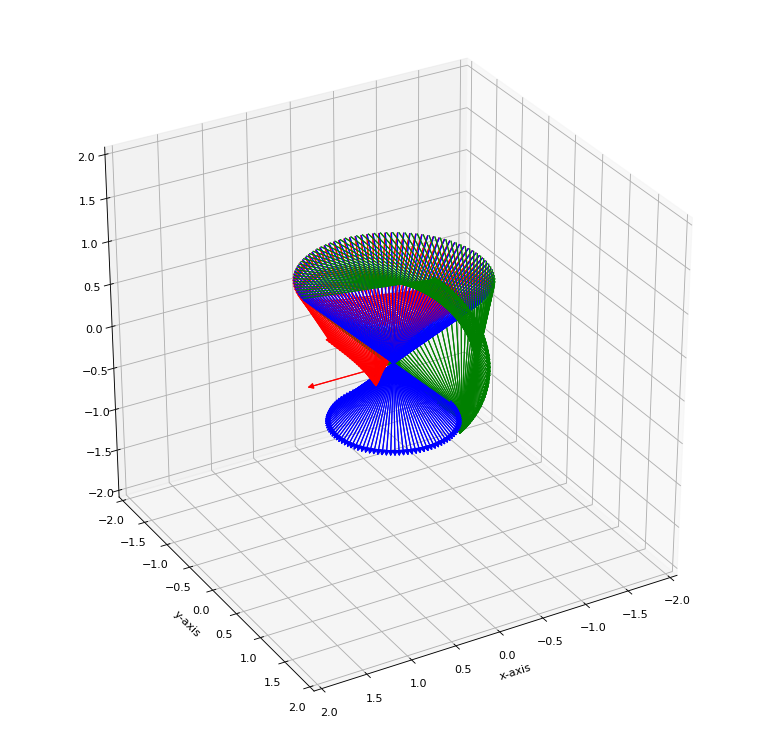

In [84]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)

draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)

pts = create_points_on_circle(100, 1.0, 1.0)

curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))
calc_points, dist =visualize_rodriguez_matrix_orientation_quat(pts,  fig, ax)
#rms = rmse(calc_points, pts)
# print(rms)
# rcm_err =  rcm_error(calc_points, pts, np.array([0.0, 0.0,0.0]))
# print("rcm error:")
# print(rcm_err)        
print("Distance between angles")
print(dist)


u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
#ax.plot_wireframe(x, y, z, color="gray")
ax.view_init(30, 60)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

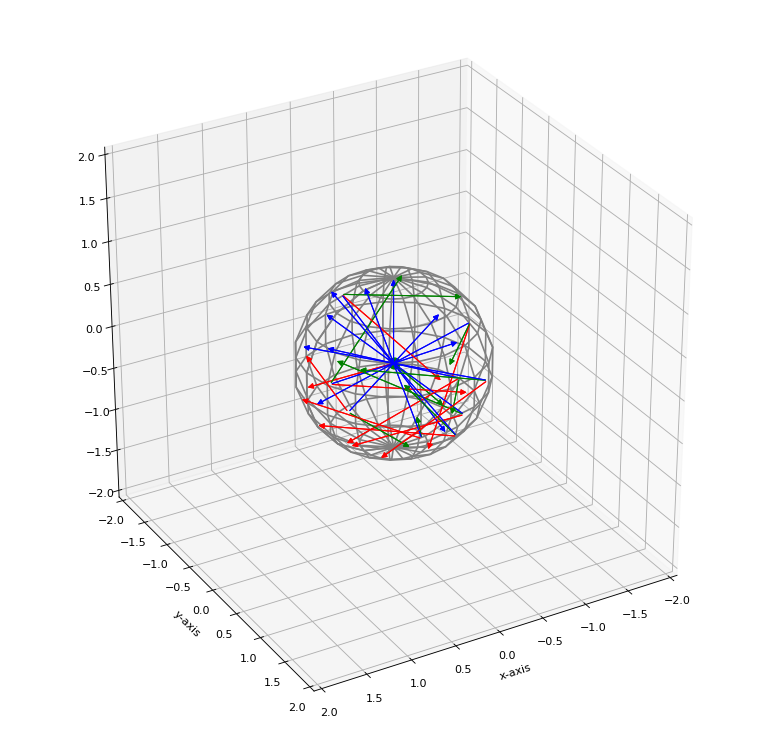

In [85]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)

draw_coordinate_system(np.eye(3), np.array([0.0, 0.0, 0.0]),fig, ax)

pts = create_points_on_sphere(10, 1.0)

curr_or = look_at(vectors[0], np.array([0.0, 0.0,0.0]), np.array([0.0, 1.0,0.0]))
visualize_rodriguez_matrix_orientation(pts,  fig, ax)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="gray")
ax.view_init(30, 60)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

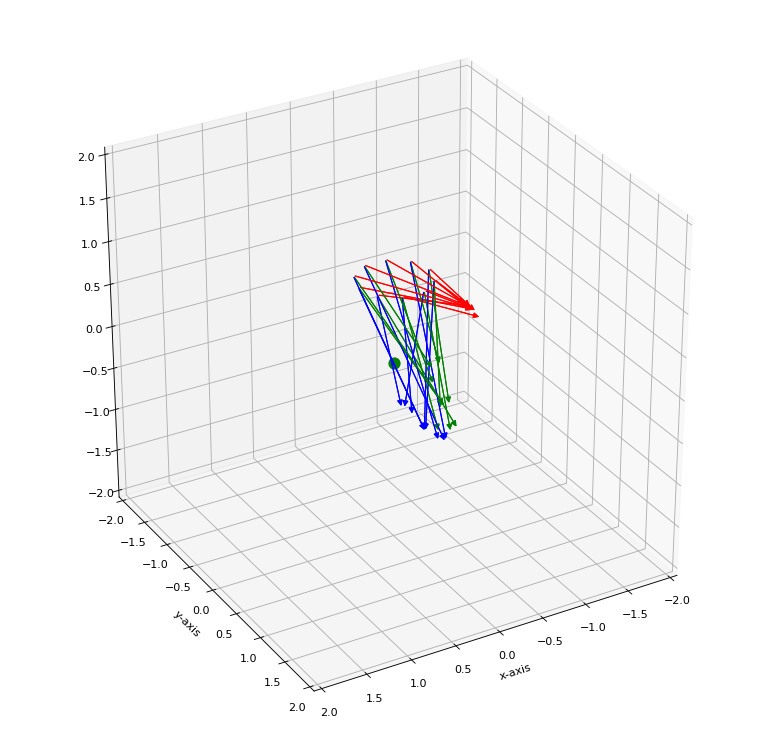

In [86]:
fig = plt.figure(num=None, figsize = (12,12), dpi = 80, facecolor ='w', edgecolor = 'k')
ax = fig.gca(projection='3d')
ax.set_xlim([-2.0,2.0])
ax.set_ylim([-2.0,2.0])
ax.set_zlim([-2.0,2.0])

ax.scatter([0],[0],[0],color="g",s=100)


number_vectors = 10
rad = 2 * np.pi / number_vectors
radius = 0.4
vectors = []


for i in range(number_vectors):
    x = np.cos(rad * i) * radius
    y = np.sin(rad * i) * radius
    z = 1.0
    vec = np.array([x,y,z])
    vectors.append(vec)


la_center = np.array([vectors[0].item(0), vectors[0].item(1), vectors[0].item(2)])
look_at_mat = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))    
draw_coordinate_system(look_at_mat, la_center, fig, ax)
t = vectors.pop(0)
for v in vectors:
    la_center = np.array([v.item(0), v.item(1), v.item(2)])
    rot_mat = look_at(la_center,np.array([0.0, 0.0, 0.0]), np.array([0.0, 1.0, 0.0]))
    
    look_at_mat = np.matmul(np.transpose(rot_mat),look_at_mat)    
    look_at_mat = np.matmul(look_at_mat,rot_mat)
    draw_coordinate_system(look_at_mat, la_center, fig, ax)

plt.xlabel('x-axis')
plt.ylabel('y-axis')
ax.view_init(30, 60)
plt.show()

In [87]:
import ipyvolume as ipv


start_vec = np.array([-2,2,1])
end_vec = np.array([2,2,1])

vectors = create_points_on_line(start_vec, end_vec, 100)

vec_orientation = []
vec_orientation.append(vectors[0])

for i in range(1, len(vectors)):
    vec_orientation.append(calculate_rodriguez_formular_vector_form(vectors[i-1], vectors[i]))


x= np.zeros(shape=(1,len(vectors))) 
y= np.zeros(shape=(1,len(vectors))) 
z= np.zeros(shape=(1,len(vectors))) 
u= np.zeros(shape=(1,len(vectors))) 
v= np.zeros(shape=(1,len(vectors)))
w= np.zeros(shape=(1,len(vectors)))     

for i in range(len(vectors)):
    x.itemset((i), vectors[i].item(0))
    np.transpose(x)
    y.itemset((i), vectors[i].item(1))
    np.transpose(y)
    z.itemset((i), vectors[i].item(2))
    np.transpose(z)
    u.itemset((0,i), -vec_orientation[i].item(0))
    np.transpose(u)
    v.itemset((0,i), -vec_orientation[i].item(1))
    np.transpose(v)
    w.itemset((0,i), -vec_orientation[i].item(2))
    np.transpose(w)
    
x = np.transpose(x)
y = np.transpose(y)
z = np.transpose(z)
u = np.transpose(u)
v = np.transpose(v)
w = np.transpose(w)

quiver = ipv.quiver(x, y, z, u, v, w, size=15)
ipv.xyzlim(-2,2)
ipv.animation_control(quiver, interval=200)

In [88]:
vectors = create_points_on_circle(100, 1.0, 1)

vec_orientation = []
vec_orientation.append(vectors[0])

for i in range(1, len(vectors)):
    vec_orientation.append(calculate_rodriguez_formular_vector_form(vectors[i-1], vectors[i]))

x= np.zeros(shape=(1,len(vectors))) 
y= np.zeros(shape=(1,len(vectors))) 
z= np.zeros(shape=(1,len(vectors))) 
u= np.zeros(shape=(1,len(vectors))) 
v= np.zeros(shape=(1,len(vectors)))
w= np.zeros(shape=(1,len(vectors)))     

for i in range(len(vectors)):
    x.itemset((i), vectors[i].item(0))
    np.transpose(x)
    y.itemset((i), vectors[i].item(1))
    np.transpose(y)
    z.itemset((i), vectors[i].item(2))
    np.transpose(z)
    u.itemset((0,i), -vec_orientation[i].item(0))
    np.transpose(u)
    v.itemset((0,i), -vec_orientation[i].item(1))
    np.transpose(v)
    w.itemset((0,i), -vec_orientation[i].item(2))
    np.transpose(w)
    
x = np.transpose(x)
y = np.transpose(y)
z = np.transpose(z)
u = np.transpose(u)
v = np.transpose(v)
w = np.transpose(w)

quiver = ipv.quiver(x, y, z, u, v, w, size=15)
ipv.xyzlim(-2,2)
ipv.animation_control(quiver, interval=200)
ipv.show()

In [89]:
print(np.random.random((6, 10))*2-1)

[[-0.284823834 -0.128591607  0.64440674   0.056847701  0.2448275
  -0.676407374 -0.077999734  0.548757186 -0.394741997  0.449234174]
 [-0.848564621 -0.381598917 -0.653123608 -0.294679305 -0.698416205
   0.326192523 -0.224116056  0.988339142 -0.055135405  0.25680358 ]
 [ 0.683537565 -0.094661319 -0.629329839  0.898159948 -0.848802997
  -0.506760978 -0.763541142  0.758566099  0.059979182 -0.922607293]
 [ 0.709879884  0.980483716  0.506390401 -0.07491257  -0.18341868
   0.299213665  0.474107661  0.806898996 -0.854130835 -0.942612039]
 [ 0.424802611  0.811568381  0.773785281  0.921719244 -0.250688228
  -0.547067346 -0.125468813  0.890874521  0.423427369 -0.846812992]
 [ 0.436206404 -0.173705008  0.480148092  0.185970914  0.72349366
  -0.387943081  0.427139136 -0.484462789 -0.263581495 -0.862759607]]
